#1. Introducción y Objetivo de la Preparación

En esta etapa del proyecto seguimos la metodología CRISP-DM, ubicándonos en la fase de Preparación de los Datos. El objetivo principal de este notebook es transformar y construir un dataset que esté listo para su uso en la fase de modelado, garantizando que los datos sean relevantes, consistentes y estén estructurados de manera óptima para entrenar modelos de machine learning.

Durante la fase previa (Comprensión de los Datos), identificamos múltiples fuentes de información relevantes: train.csv, test.csv, historical_transactions.csv, new_merchant_transactions.csv y merchants.csv. También detectamos distintos problemas de calidad de datos, como valores faltantes, outliers, y estructuras que requerían integrarse.

Por tanto, en esta notebook ejecutaremos las tareas necesarias para:

- Seleccionar atributos pertinentes para el modelado desde las distintas fuentes.

- Integrar adecuadamente las tablas relacionales (joins y agregaciones).

- Limpiar los datos detectados como problemáticos.

- Generar nuevas variables a partir del comportamiento transaccional de los usuarios.

- Transformar el dataset final a un formato y estructura compatibles con algoritmos de modelado.

El resultado final será un dataset preparado y curado que contenga una representación sintética de cada tarjeta (card_id), con variables numéricas y categóricas que permitan predecir de forma eficaz el loyalty score.

##Resumen de decisiones tomadas durante la fase de comprensión de los datos (por ejemplo, limpieza, selección de atributos).
Durante la fase de comprensión de los datos se analizaron las distintas fuentes de información provistas por Elo: datos de clientes (train.csv), transacciones históricas (historical_transactions.csv), transacciones recientes (new_merchant_transactions.csv) y características de los comercios (merchants.csv). Este análisis permitió identificar patrones clave, valores ausentes, relaciones entre variables y posibles outliers.

En base a los hallazgos anteriores, la fase de preparación de datos tiene como objetivo transformar estos datos crudos en un conjunto estructurado, limpio y listo para alimentar modelos de aprendizaje automático supervisado. Las principales decisiones tomadas que guían esta etapa son:

- El score de lealtad (target) es una variable continua y será predicho mediante un modelo de regresión.

- Se seleccionaron variables relevantes de cada archivo, considerando tanto su correlación potencial con la variable objetivo como su valor semántico en el contexto del negocio.

- Se detectaron variables con valores faltantes y outliers, que requerirán tratamiento adecuado.

- Se observó que muchas variables relevantes provienen de las transacciones, por lo que se realizarán agregaciones por cliente (card_id) para construir una matriz de datos con un registro por cliente.

- Las variables temporales tienen potencial para capturar estacionalidad, antigüedad y frecuencia, por lo que serán transformadas y derivadas.

- Se aplicará codificación a variables categóricas y se descartarán aquellas con baja varianza o sin valor informativo.

#2. Selección de Datos

##Variables del archivo train.csv
- card_id: Identificador único del cliente. Será la clave principal para unir los datasets.

- first_active_month: Se utilizará para derivar la antigüedad del cliente.

- feature_1, feature_2, feature_3: Variables categóricas internas provistas por Elo. Si bien su significado exacto no está documentado, muestran cierta variabilidad entre clientes y potencialmente capturan preferencias o segmentaciones internas.

Estas variables representan el punto de partida del cliente en la plataforma y pueden capturar segmentaciones internas o ciclos de vida que impactan en su lealtad futura.

##Variables derivadas del archivo historical_transactions.csv (agregadas por card_id)
- purchase_amount: Se agregará como total, promedio, desviación estándar y percentiles. Mide el volumen histórico de gasto.

- installments: Agregado como promedio, mediana y proporción de pagos a cuotas. Refleja el tipo de consumo (efectivo vs crédito).

- purchase_date: Se extraerán variables de tiempo como antigüedad de la última compra, dispersión temporal entre compras y estacionalidad.

- month_lag: Permite agrupar transacciones por su antigüedad relativa.

- authorized_flag: Porcentaje de transacciones aprobadas. Mide fiabilidad del cliente.

- category_1, category_2, category_3: Codificadas como proporciones o frecuencias. Capturan tipo de promoción o categoría del gasto.

- merchant_category_id, state_id, city_id: Se usará diversidad (número único de categorías o ubicaciones visitadas). Refleja amplitud geográfica y de intereses.

Estas variables son fundamentales para entender el comportamiento histórico del cliente, sus patrones de gasto, regularidad y preferencias. Permiten inferir su valor y fidelidad previa al sistema de Elo.

##Variables derivadas del archivo new_merchant_transactions.csv
- Misma estructura y tratamiento que historical_transactions, pero se analizarán como indicadores de comportamiento reciente (últimos comercios visitados).

Permiten medir el comportamiento del cliente frente a nuevos comercios, lo que es clave para inferir respuesta a campañas, apertura al cambio y potencial de exploración comercial. Clientes activos con nuevos comercios pueden tener mayor probabilidad de lealtad futura.

##Variables del archivo merchants.csv (vinculadas vía merchant_id)
- avg_sales_lag3, avg_sales_lag6, etc.: Indicadores del dinamismo del comercio.

- most_recent_sales_range, most_recent_purchases_range: Codifican la intensidad comercial más reciente. Se codificarán ordinalmente.

- merchant_category_id, category_1, category_4: Se cruzarán con las transacciones para crear representaciones de afinidad del cliente con ciertas categorías o tipos de comercio.

El tipo de comercio influye en el patrón de compra del cliente. Al cruzarlo con los hábitos del cliente, se pueden obtener variables que midan la compatibilidad cliente–comercio.

##Variables descartadas o no priorizadas
- subsector_id, category_name: Alta cardinalidad, bajo control semántico. Serán descartadas a menos que pruebas futuras muestren valor predictivo.

- Variables como merchant_id y merchant_group_id no se usarán directamente, pero servirán como llaves de agregación.

- Transacciones no autorizadas: Si representan un porcentaje muy pequeño (<5%), pueden ser descartadas por ruido.

- Variables con más del 90% de valores nulos o con baja varianza.

##Enfoque adicional orientado al producto
- Clientes con gran diversidad de categorías y alta frecuencia reciente podrían representar perfiles altamente leales o promotores. Este tipo de hipótesis será validada en el modelado.

- Se prestará atención a variables que permitan explicar no solo el monto gastado, sino el nivel de compromiso con la plataforma, como uso recurrente, exploración de nuevos comercios y respuesta a promociones.

In [3]:
import pandas as pd
train = pd.read_csv("src/train.csv", parse_dates=["first_active_month"])
historical = pd.read_csv("src/historical_transactions.csv", parse_dates=["purchase_date"])
new_merchant = pd.read_csv("src/new_merchant_transactions.csv", parse_dates=["purchase_date"])
merchants = pd.read_csv("src/merchants.csv")

In [5]:

train_selected = train[["card_id", "first_active_month", "feature_1", "feature_2", "feature_3", "target"]]


historical_selected = historical[
    ["card_id", "purchase_date", "purchase_amount", "installments", "month_lag",
     "category_1", "category_2", "category_3", "merchant_id", "state_id", "city_id"]
]


new_merchant_selected = new_merchant[
    ["card_id", "purchase_date", "purchase_amount", "installments", "month_lag",
     "category_1", "category_2", "category_3", "merchant_id", "state_id", "city_id"]
]

merchants_selected = merchants[
    ["merchant_id", "merchant_group_id", "category_1", "category_2", "avg_sales_lag3",
     "avg_sales_lag6", "avg_sales_lag12", "avg_purchases_lag3", "avg_purchases_lag6", 
     "avg_purchases_lag12", "most_recent_sales_range", "most_recent_purchases_range",
     "category_4", "city_id", "state_id"]
]


In [7]:

train_selected.to_csv("src/train_selected.csv", index=False)
historical_selected.to_csv("src/historical_selected.csv", index=False)
new_merchant_selected.to_csv("src/new_merchant_selected.csv", index=False)
merchants_selected.to_csv("src/merchants_selected.csv", index=False)


In [13]:
train_selected.head()


,card_id,first_active_month,feature_1,feature_2,feature_3,target
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820283
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392913
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056
3,C_ID_186d6a6901,2017-09-01,4,3,0,0.142495
4,C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749


In [15]:
historical_selected.head()


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
0,C_ID_4e6213e9bc,2017-06-25 15:33:07,-0.703331,0,-8,N,1.0,A,M_ID_e020e9b302,16,88
1,C_ID_4e6213e9bc,2017-07-15 12:10:45,-0.733128,0,-7,N,1.0,A,M_ID_86ec983688,16,88
2,C_ID_4e6213e9bc,2017-08-09 22:04:29,-0.720386,0,-6,N,1.0,A,M_ID_979ed661fc,16,88
3,C_ID_4e6213e9bc,2017-09-02 10:06:26,-0.735352,0,-5,N,1.0,A,M_ID_e6d5ae8ea6,16,88
4,C_ID_4e6213e9bc,2017-03-10 01:14:19,-0.722865,0,-11,N,1.0,A,M_ID_e020e9b302,16,88


In [17]:
new_merchant_selected.head()


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
0,C_ID_415bb3a509,2018-03-11 14:57:36,-0.557574,1,1,N,1.0,B,M_ID_b0c793002c,9,107
1,C_ID_415bb3a509,2018-03-19 18:53:37,-0.569580,1,1,N,1.0,B,M_ID_88920c89e8,9,140
2,C_ID_415bb3a509,2018-04-26 14:08:44,-0.551037,1,2,N,1.0,B,M_ID_ad5237ef6b,9,330
3,C_ID_415bb3a509,2018-03-07 09:43:21,-0.671925,1,1,Y,NaN,B,M_ID_9e84cda3b1,-1,-1
4,C_ID_ef55cf8d4b,2018-03-22 21:07:53,-0.659904,1,1,Y,NaN,B,M_ID_3c86fa3831,-1,-1


In [19]:
merchants_selected.head()

,merchant_id,merchant_group_id,category_1,category_2,avg_sales_lag3,avg_sales_lag6,avg_sales_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_purchases_lag12,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id
0,M_ID_838061e48c,8353,N,1.0,-0.40,-2.25,-2.32,9.666667,18.666667,13.916667,E,E,N,242,9
1,M_ID_9339d880ad,3184,N,1.0,-0.72,-0.74,-0.57,1.750000,1.291667,1.687500,E,E,N,22,16
2,M_ID_e726bbae1e,447,N,5.0,-82.13,-82.13,-82.13,260.000000,260.000000,260.000000,E,E,N,-1,5
3,M_ID_a70e9c5f81,5026,Y,NaN,NaN,NaN,NaN,1.666667,4.666667,3.833333,E,E,Y,-1,-1
4,M_ID_64456c37ce,2228,Y,NaN,NaN,NaN,NaN,0.500000,0.361111,0.347222,E,E,Y,-1,-1


#3. Limpieza de los Datos

##Imputación de valores faltantes.

In [21]:
def mostrar_nulos(df, nombre):
    print(f"\nValores nulos en: {nombre}")
    print(df.isnull().sum()[df.isnull().sum() > 0])


In [23]:
mostrar_nulos(train_selected, "train_selected")
mostrar_nulos(historical_selected, "historical_selected")
mostrar_nulos(new_merchant_selected, "new_merchant_selected")
mostrar_nulos(merchants_selected, "merchants_selected")



Valores nulos en: train_selected
Series([], dtype: int64)

Valores nulos en: historical_selected
category_2     2652864
category_3      178159
merchant_id     138481
dtype: int64

Valores nulos en: new_merchant_selected
category_2     111745
category_3      55922
merchant_id     26216
dtype: int64

Valores nulos en: merchants_selected
category_2         11887
avg_sales_lag3        13
avg_sales_lag6        13
avg_sales_lag12       13
dtype: int64


In [31]:
def imputar_datos(df, definicion_columnas, nombre):
    print(f"\nImputando valores en: {nombre}")
    for columna, metodo in definicion_columnas.items():
        if columna in df.columns:
            if metodo == "cero":
                df.loc[:, columna] = df[columna].fillna(0)
            elif metodo == "media":
                df.loc[:, columna] = df[columna].fillna(df[columna].mean())
            elif metodo == "mediana":
                df.loc[:, columna] = df[columna].fillna(df[columna].median())
            elif metodo == "moda":
                df.loc[:, columna] = df[columna].fillna(df[columna].mode()[0])
            elif metodo == "desconocido":
                df.loc[:, columna] = df[columna].fillna("Unknown")
            elif metodo == "N":
                df.loc[:, columna] = df[columna].fillna("N")
            elif metodo == "fecha":
                df.loc[:, columna] = df[columna].fillna("1900-01-01")



In [33]:
train_def = {
    "first_active_month": "fecha",
    "feature_1": "cero",
    "feature_2": "cero",
    "feature_3": "cero",
    "target": "mediana"
}

historical_def = {
    "purchase_date": "fecha",
    "purchase_amount": "cero",
    "installments": "cero",
    "month_lag": "cero",
    "category_1": "N",
    "category_2": "desconocido",
    "category_3": "desconocido",
    "merchant_id": "desconocido",
    "state_id": "desconocido",
    "city_id": "desconocido"
}

new_merchant_def = historical_def.copy()

merchants_def = {
    "merchant_group_id": "desconocido",
    "category_1": "N",
    "category_2": "desconocido",
    "avg_sales_lag3": "cero",
    "avg_sales_lag6": "cero",
    "avg_sales_lag12": "cero",
    "avg_purchases_lag3": "cero",
    "avg_purchases_lag6": "cero",
    "avg_purchases_lag12": "cero",
    "most_recent_sales_range": "desconocido",
    "most_recent_purchases_range": "desconocido",
    "category_4": "N",
    "city_id": "desconocido",
    "state_id": "desconocido"
}


In [35]:
imputar_datos(train_selected, train_def, "train_selected")
imputar_datos(historical_selected, historical_def, "historical_selected")
imputar_datos(new_merchant_selected, new_merchant_def, "new_merchant_selected")
imputar_datos(merchants_selected, merchants_def, "merchants_selected")



Imputando valores en: train_selected

Imputando valores en: historical_selected

Imputando valores en: new_merchant_selected

Imputando valores en: merchants_selected


In [37]:
mostrar_nulos(train_selected, "train_selected")
mostrar_nulos(historical_selected, "historical_selected")
mostrar_nulos(new_merchant_selected, "new_merchant_selected")
mostrar_nulos(merchants_selected, "merchants_selected")



Valores nulos en: train_selected
Series([], dtype: int64)

Valores nulos en: historical_selected
Series([], dtype: int64)

Valores nulos en: new_merchant_selected
Series([], dtype: int64)

Valores nulos en: merchants_selected
Series([], dtype: int64)


##Detección y tratamiento de outliers.

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

columnas_train = ["feature_1", "feature_2", "feature_3", "target"]
columnas_hist = ["purchase_amount", "installments", "month_lag"]
columnas_merchant = [
    "avg_sales_lag3", "avg_sales_lag6", "avg_sales_lag12",
    "avg_purchases_lag3", "avg_purchases_lag6", "avg_purchases_lag12"
]


In [50]:
def graficar_boxplots(df, columnas, titulo):
    filas = (len(columnas) + 2) // 3
    plt.figure(figsize=(15, 5 * filas))
    for i, col in enumerate(columnas, 1):
        plt.subplot(filas, 3, i)
        sns.boxplot(x=df[col], color="skyblue", fliersize=3)
        plt.title(f"{titulo} - {col}")
        plt.tight_layout()
    plt.show()


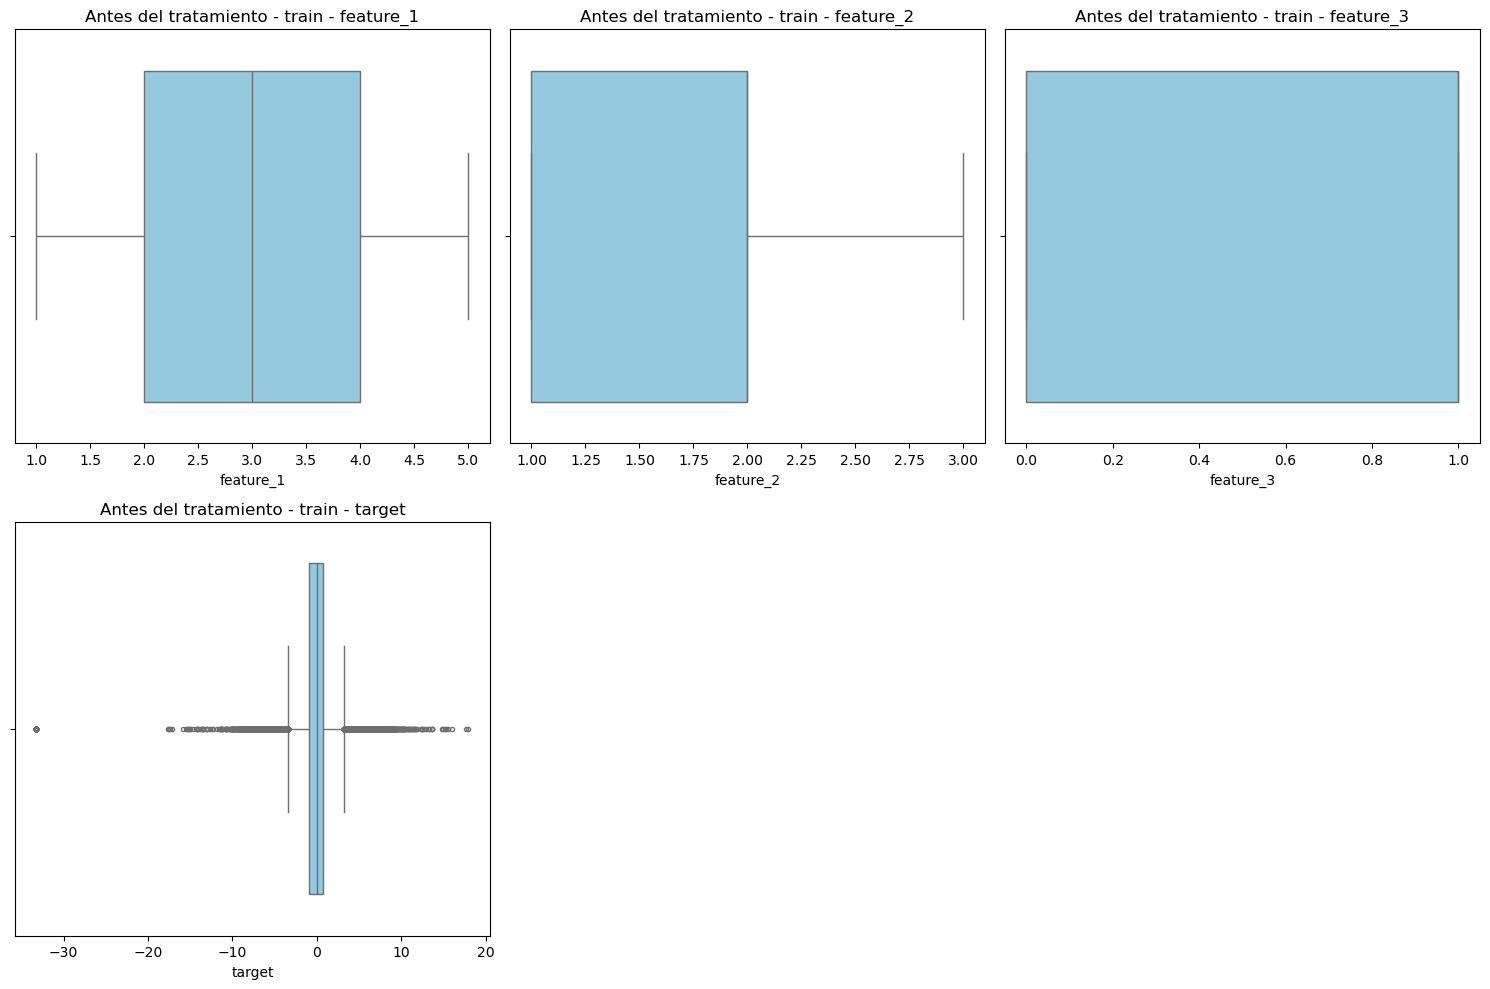

In [54]:
graficar_boxplots(train_selected, columnas_train, "Antes del tratamiento - train")



In [62]:
def detectar_outliers(df, columnas):
    outliers = {}
    for col in columnas:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            outlier_mask = (df[col] < limite_inferior) | (df[col] > limite_superior)
            total_outliers = outlier_mask.sum()
            if total_outliers > 0:
                outliers[col] = total_outliers
    return outliers


In [64]:
print(detectar_outliers(train_selected, columnas_train))
print(detectar_outliers(historical_selected, columnas_hist))
print(detectar_outliers(new_merchant_selected, columnas_hist))
print(detectar_outliers(merchants_selected, columnas_merchant))


{'target': np.int64(15397)}
{'purchase_amount': np.int64(2907482), 'installments': np.int64(1178517)}
{'purchase_amount': np.int64(200708), 'installments': np.int64(93958)}
{'avg_sales_lag3': np.int64(36638), 'avg_sales_lag6': np.int64(36260), 'avg_sales_lag12': np.int64(35822), 'avg_purchases_lag3': np.int64(37533), 'avg_purchases_lag6': np.int64(36444), 'avg_purchases_lag12': np.int64(35721)}


In [66]:
def tratar_outliers(df, columnas, metodo="mediana"):
    for col in columnas:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            if metodo == "mediana":
                valor_reemplazo = df[col].median()
            elif metodo == "media":
                valor_reemplazo = df[col].mean()
            else:
                continue  
            df.loc[df[col] < limite_inferior, col] = valor_reemplazo
            df.loc[df[col] > limite_superior, col] = valor_reemplazo


In [68]:
tratar_outliers(train_selected, columnas_train, metodo="mediana")
tratar_outliers(historical_selected, columnas_hist, metodo="mediana")
tratar_outliers(new_merchant_selected, columnas_hist, metodo="mediana")
tratar_outliers(merchants_selected, columnas_merchant, metodo="mediana")


In [70]:
print(detectar_outliers(train_selected, columnas_train))
print(detectar_outliers(historical_selected, columnas_hist))
print(detectar_outliers(new_merchant_selected, columnas_hist))
print(detectar_outliers(merchants_selected, columnas_merchant))

{'target': np.int64(8705)}
{'purchase_amount': np.int64(2462362)}
{'purchase_amount': np.int64(140314)}
{'avg_sales_lag3': np.int64(25845), 'avg_sales_lag6': np.int64(19927), 'avg_sales_lag12': np.int64(22006), 'avg_purchases_lag3': np.int64(24397), 'avg_purchases_lag6': np.int64(22985), 'avg_purchases_lag12': np.int64(21105)}


##Corrección de valores erróneos, inconsistentes o duplicados.

In [72]:
def mostrar_duplicados(df, nombre_df="DataFrame"):
    duplicados = df[df.duplicated()]
    n = len(duplicados)
    print(f"{nombre_df} tiene {n} filas duplicadas.")
    if n > 0:
        display(duplicados.head(10))


In [74]:
mostrar_duplicados(train_selected, "train_selected")
mostrar_duplicados(historical_selected, "historical_selected")
mostrar_duplicados(new_merchant_selected, "new_merchant_selected")
mostrar_duplicados(merchants_selected, "merchants_selected")

train_selected tiene 0 filas duplicadas.
historical_selected tiene 37353 filas duplicadas.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
4165,C_ID_b45d4d37b1,2017-12-15 14:16:49,-0.728876,1,-2,N,5.0,B,M_ID_b0feef5844,21,120
6576,C_ID_ad99f08d4c,2017-02-18 11:00:21,-0.688349,2,-12,N,1.0,C,M_ID_0ecf00e563,9,265
8478,C_ID_9e6b3e491a,2017-11-30 00:00:00,-0.706336,0,-3,N,3.0,A,M_ID_6dc4ef819f,2,244
9235,C_ID_23518d5fe7,2017-11-11 00:00:00,-0.585914,0,-3,N,1.0,A,M_ID_2637773dd2,9,69
9756,C_ID_3df86e0089,2017-10-09 15:57:33,-0.688349,1,-4,Y,Unknown,B,M_ID_9139332ccc,-1,-1
11006,C_ID_aa76adb703,2017-11-19 00:00:00,-0.688349,0,-3,N,Unknown,A,M_ID_cfa52d2ea7,-1,-1
11296,C_ID_9deaeaf200,2017-12-07 23:04:49,-0.724368,0,-1,N,1.0,A,M_ID_50f575c681,9,69
12308,C_ID_bdf550bccd,2017-11-28 14:18:48,-0.725871,1,-3,N,1.0,B,M_ID_50f575c681,9,69
12597,C_ID_6107f3d6c2,2017-04-24 20:20:07,-0.480247,0,-10,N,1.0,A,M_ID_1d574aaed2,9,314
12723,C_ID_5b28e30255,2017-11-20 00:00:00,-0.544050,0,-3,N,4.0,A,M_ID_e5517e40fa,4,212


new_merchant_selected tiene 38 filas duplicadas.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
2180,C_ID_8222fde29c,2017-11-25 00:00:00,-0.674841,1,2,N,5.0,B,M_ID_7c02abc1a8,5,143
26003,C_ID_6c40424ee1,2018-03-26 16:03:15,-0.674841,1,1,N,5.0,C,M_ID_a87d7378ac,21,333
47118,C_ID_63c8bf7aa3,2017-08-27 13:26:18,-0.674841,1,1,Y,Unknown,C,M_ID_9139332ccc,-1,-1
73148,C_ID_8cce90e147,2018-04-20 16:32:56,-0.674841,1,2,Y,Unknown,C,M_ID_a87d7378ac,-1,-1
124189,C_ID_340d462d08,2017-11-27 00:00:00,-0.674841,-1,2,N,3.0,Unknown,M_ID_e869fb25e6,1,292
124195,C_ID_340d462d08,2017-11-27 00:00:00,-0.674841,-1,2,N,3.0,Unknown,M_ID_29973526c5,1,292
124202,C_ID_340d462d08,2017-11-24 00:00:00,-0.674841,-1,2,N,3.0,Unknown,M_ID_bdc1984a9b,11,87
184127,C_ID_98a7d50899,2018-03-23 23:46:23,-0.674841,1,1,Y,Unknown,C,M_ID_9139332ccc,-1,-1
184391,C_ID_a957743c02,2017-11-24 00:00:00,-0.674841,-1,1,N,3.0,Unknown,M_ID_7c7d314035,1,246
252268,C_ID_fdf47fda44,2018-03-29 16:44:20,-0.674841,1,2,N,5.0,C,M_ID_a87d7378ac,21,333


merchants_selected tiene 0 filas duplicadas.


In [80]:
def eliminar_duplicados(df, nombre_df="DataFrame"):
    duplicados = df.duplicated().sum()
    if duplicados > 0:
        print(f"{nombre_df}: {duplicados} filas duplicadas eliminadas.")
        df_sin_duplicados = df.drop_duplicates()
        return df_sin_duplicados
    else:
        print(f"{nombre_df}: No se encontraron filas duplicadas.")
        return df



In [82]:
eliminar_duplicados(train_selected, "train_selected")
eliminar_duplicados(historical_selected, "historical_selected")
eliminar_duplicados(new_merchant_selected, "new_merchant_selected")
eliminar_duplicados(merchants_selected, "merchants_selected")


train_selected: No se encontraron filas duplicadas.
historical_selected: No se encontraron filas duplicadas.
new_merchant_selected: No se encontraron filas duplicadas.
merchants_selected: No se encontraron filas duplicadas.


,merchant_id,merchant_group_id,category_1,category_2,avg_sales_lag3,avg_sales_lag6,avg_sales_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_purchases_lag12,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id
0,M_ID_838061e48c,8353,N,1.0,1.00,1.01,1.02,1.016667,1.026961,1.043361,E,E,N,242,9
1,M_ID_9339d880ad,3184,N,1.0,1.00,1.01,1.02,1.016667,1.291667,1.687500,E,E,N,22,16
2,M_ID_e726bbae1e,447,N,5.0,1.00,1.01,1.02,1.016667,1.026961,1.043361,E,E,N,-1,5
3,M_ID_a70e9c5f81,5026,Y,Unknown,1.00,1.01,1.02,1.016667,1.026961,1.043361,E,E,Y,-1,-1
4,M_ID_64456c37ce,2228,Y,Unknown,1.00,1.01,1.02,1.016667,1.026961,0.347222,E,E,Y,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,N,1.0,1.00,0.99,1.00,1.022618,1.019505,1.024796,A,A,Y,69,9
334692,M_ID_725a60d404,35,Y,Unknown,0.89,0.78,0.59,0.927684,0.813473,0.606765,A,A,Y,-1,-1
334693,M_ID_f2045dd267,35,N,5.0,0.96,0.90,0.74,0.982957,0.924769,0.750763,A,A,Y,160,21
334694,M_ID_9139332ccc,35,Y,Unknown,0.94,0.82,0.65,0.919558,0.783000,0.584000,A,A,Y,-1,-1


In [84]:
def mostrar_negativos(df, columnas, nombre_df="DataFrame"):
    for col in columnas:
        if col in df.columns:
            negativos = df[df[col] < 0]
            n = len(negativos)
            print(f"{nombre_df} - '{col}' tiene {n} valores negativos.")
            if n > 0:
                display(negativos.head(10))


In [86]:
columnas_num_historical = ["purchase_amount", "installments"]
columnas_num_new_merchant = ["purchase_amount", "installments"]

mostrar_negativos(historical_selected, columnas_num_historical, "historical_selected")
mostrar_negativos(new_merchant_selected, columnas_num_new_merchant, "new_merchant_selected")

historical_selected - 'purchase_amount' tiene 29075008 valores negativos.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
0,C_ID_4e6213e9bc,2017-06-25 15:33:07,-0.703331,0,-8,N,1.0,A,M_ID_e020e9b302,16,88
1,C_ID_4e6213e9bc,2017-07-15 12:10:45,-0.733128,0,-7,N,1.0,A,M_ID_86ec983688,16,88
2,C_ID_4e6213e9bc,2017-08-09 22:04:29,-0.720386,0,-6,N,1.0,A,M_ID_979ed661fc,16,88
3,C_ID_4e6213e9bc,2017-09-02 10:06:26,-0.735352,0,-5,N,1.0,A,M_ID_e6d5ae8ea6,16,88
4,C_ID_4e6213e9bc,2017-03-10 01:14:19,-0.722865,0,-11,N,1.0,A,M_ID_e020e9b302,16,88
5,C_ID_4e6213e9bc,2018-02-24 08:45:05,-0.734887,0,0,N,1.0,A,M_ID_50af771f8d,9,333
6,C_ID_4e6213e9bc,2017-03-21 00:10:51,-0.716855,0,-11,N,1.0,A,M_ID_5e8220e564,16,88
7,C_ID_4e6213e9bc,2017-11-18 20:05:55,-0.657049,0,-3,N,1.0,A,M_ID_9d41786a50,16,3
8,C_ID_4e6213e9bc,2017-06-01 22:02:56,-0.737967,0,-8,N,1.0,A,M_ID_979ed661fc,16,88
9,C_ID_4e6213e9bc,2017-03-16 15:41:22,-0.715352,0,-11,N,1.0,A,M_ID_74ba14b5fc,16,88


historical_selected - 'installments' tiene 176729 valores negativos.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
885,C_ID_fc8e41b9cf,2018-01-23 12:05:13,-0.688349,-1,-1,N,3.0,Unknown,M_ID_c4f5972059,8,251
914,C_ID_fc8e41b9cf,2018-02-21 07:24:59,-0.688349,-1,0,N,3.0,Unknown,M_ID_bc5663de31,8,251
936,C_ID_fc8e41b9cf,2017-11-13 00:00:00,-0.475694,-1,-3,N,3.0,Unknown,M_ID_0f437c5559,8,251
941,C_ID_fc8e41b9cf,2018-01-09 14:15:12,-0.551563,-1,-1,N,3.0,Unknown,M_ID_b7441bb10f,8,170
965,C_ID_fc8e41b9cf,2018-01-23 14:04:39,-0.688349,-1,-1,N,3.0,Unknown,M_ID_1dd8347bcb,8,251
992,C_ID_fc8e41b9cf,2017-11-27 00:00:00,-0.688349,-1,-3,N,3.0,Unknown,M_ID_d12eaa9bd7,8,251
1003,C_ID_fc8e41b9cf,2017-12-05 11:32:24,-0.538791,-1,-2,N,3.0,Unknown,M_ID_b39aa08d22,8,251
1031,C_ID_fc8e41b9cf,2018-01-06 10:40:46,-0.611669,-1,-1,N,3.0,Unknown,M_ID_944c5bc932,8,170
1035,C_ID_fc8e41b9cf,2017-12-06 10:58:34,-0.521510,-1,-2,N,3.0,Unknown,M_ID_4838a2855e,8,170
2329,C_ID_058b254a5b,2017-12-16 10:06:39,-0.581616,-1,-2,N,1.0,Unknown,M_ID_a225855c6f,9,233


new_merchant_selected - 'purchase_amount' tiene 1962993 valores negativos.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
0,C_ID_415bb3a509,2018-03-11 14:57:36,-0.557574,1,1,N,1.0,B,M_ID_b0c793002c,9,107
1,C_ID_415bb3a509,2018-03-19 18:53:37,-0.569580,1,1,N,1.0,B,M_ID_88920c89e8,9,140
2,C_ID_415bb3a509,2018-04-26 14:08:44,-0.551037,1,2,N,1.0,B,M_ID_ad5237ef6b,9,330
3,C_ID_415bb3a509,2018-03-07 09:43:21,-0.671925,1,1,Y,Unknown,B,M_ID_9e84cda3b1,-1,-1
4,C_ID_ef55cf8d4b,2018-03-22 21:07:53,-0.659904,1,1,Y,Unknown,B,M_ID_3c86fa3831,-1,-1
5,C_ID_ef55cf8d4b,2018-04-02 12:53:28,-0.633007,1,2,N,1.0,B,M_ID_8874615e00,9,231
6,C_ID_ef55cf8d4b,2018-03-28 19:50:19,-0.674841,1,1,N,1.0,B,M_ID_6d061b5ddc,9,69
7,C_ID_ef55cf8d4b,2018-04-05 08:06:52,-0.553787,1,2,N,1.0,B,M_ID_df1e022f41,9,231
8,C_ID_ef55cf8d4b,2018-04-07 18:37:40,-0.596643,1,2,N,1.0,B,M_ID_d15eae0468,9,69
9,C_ID_ef55cf8d4b,2018-03-17 18:10:41,-0.607191,1,1,N,1.0,B,M_ID_5f9bffd028,9,69


new_merchant_selected - 'installments' tiene 55914 valores negativos.


,card_id,purchase_date,purchase_amount,installments,month_lag,category_1,category_2,category_3,merchant_id,state_id,city_id
10,C_ID_ef55cf8d4b,2018-03-31 09:55:40,-0.674841,-1,1,N,1.0,Unknown,M_ID_3ffd43b4cd,9,69
189,C_ID_fd55871fd8,2018-02-10 09:33:55,-0.674841,-1,1,N,1.0,Unknown,M_ID_2a7d376053,15,187
270,C_ID_6bf003900f,2018-03-02 18:00:10,-0.596673,-1,1,N,1.0,Unknown,M_ID_1b3e5a9b05,9,69
306,C_ID_e4d60467c2,2018-03-22 13:49:08,-0.596643,-1,1,N,1.0,Unknown,M_ID_2da56d089d,9,69
402,C_ID_cb2269c52d,2018-04-26 14:36:11,-0.416325,-1,2,N,1.0,Unknown,M_ID_6972fc7624,9,213
410,C_ID_cb2269c52d,2018-03-09 14:26:28,-0.410524,-1,1,N,1.0,Unknown,M_ID_59f6ac5d37,9,213
447,C_ID_b25d492593,2018-04-13 12:01:02,-0.686802,-1,2,N,1.0,Unknown,M_ID_9b6a46e720,16,308
448,C_ID_b25d492593,2018-04-21 07:29:12,-0.536537,-1,2,N,1.0,Unknown,M_ID_81dcc31929,16,308
468,C_ID_2bba08c2c4,2018-04-20 08:34:02,-0.611804,-1,2,N,4.0,Unknown,M_ID_f95f2434d4,4,107
641,C_ID_c5bf64ecbd,2018-03-10 08:12:11,-0.674841,-1,1,N,1.0,Unknown,M_ID_3dfd6d6de7,9,19


##Normalización de formatos (ej: fechas, strings, booleans).

In [100]:
def normalizar_formatos(df):
    for col in df.columns:
        if "date" in col.lower() or "month" in col.lower() or "fecha" in col.lower():
            try:
                df.loc[:, col] = pd.to_datetime(df[col], errors='coerce')  # convierte o pone NaT si no puede
                print(f"Columna '{col}' convertida a datetime")
            except Exception as e:
                print(f"No se pudo convertir '{col}' a datetime: {e}")

    for col in df.select_dtypes(include=["object"]).columns:
        try:
            df.loc[:, col] = df[col].astype(str).str.strip().str.lower()
            print(f"Columna '{col}' normalizada (strip + lower)")
        except Exception as e:
            print(f"No se pudo normalizar '{col}': {e}")
            
    for col in df.select_dtypes(include=["int64", "float64"]).columns:
        try:
            if pd.api.types.is_float_dtype(df[col]):
                df.loc[:, col] = df[col].astype(float)
            else:
                df.loc[:, col] = df[col].astype(int)
            print(f"Columna '{col}' convertida a tipo numérico")
        except Exception as e:
            print(f"No se pudo convertir '{col}' a tipo numérico: {e}")

    return df


In [102]:
train_selected = normalizar_formatos(train_selected)
historical_selected = normalizar_formatos(historical_selected)
new_merchant_selected = normalizar_formatos(new_merchant_selected)
merchants_selected = normalizar_formatos(merchants_selected)


Columna 'first_active_month' convertida a datetime
Columna 'card_id' normalizada (strip + lower)
Columna 'feature_1' convertida a tipo numérico
Columna 'feature_2' convertida a tipo numérico
Columna 'feature_3' convertida a tipo numérico
Columna 'target' convertida a tipo numérico
Columna 'purchase_date' convertida a datetime
Columna 'month_lag' convertida a datetime
Columna 'card_id' normalizada (strip + lower)
Columna 'category_1' normalizada (strip + lower)
Columna 'category_2' normalizada (strip + lower)
Columna 'category_3' normalizada (strip + lower)
Columna 'merchant_id' normalizada (strip + lower)
Columna 'purchase_amount' convertida a tipo numérico
Columna 'installments' convertida a tipo numérico
Columna 'state_id' convertida a tipo numérico
Columna 'city_id' convertida a tipo numérico
Columna 'purchase_date' convertida a datetime
Columna 'month_lag' convertida a datetime
Columna 'card_id' normalizada (strip + lower)
Columna 'category_1' normalizada (strip + lower)
Columna 'c

#4. Integración de Datos

##Uniones entre tablas (por ejemplo: train + transacciones + merchants).

In [ ]:
import pandas as pd

cols_merchant = [
    "merchant_group_id", "category_1", "category_2", "avg_sales_lag3",
    "avg_sales_lag6", "avg_sales_lag12", "avg_purchases_lag3",
    "avg_purchases_lag6", "avg_purchases_lag12", "most_recent_sales_range",
    "most_recent_purchases_range", "category_4", "city_id", "state_id"
]
merchants_unique = merchants_selected.drop_duplicates(subset="merchant_id")
merchant_info = merchants_unique.set_index("merchant_id")[cols_merchant]

In [ ]:
def agregar_por_chunks(df_transacciones, agg_dict, merchant_info, map_cols, chunk_size=500_000):
    acumulado = {}

    for i in range(0, len(df_transacciones), chunk_size):
        chunk = df_transacciones.iloc[i:i+chunk_size].copy()

        # Mapear columnas desde merchant_info
        for col in map_cols:
            chunk[col] = chunk["merchant_id"].map(merchant_info[col])

        # Agregamos por card_id
        agg = chunk.groupby("card_id").agg(agg_dict)

        for card_id, row in agg.iterrows():
            if card_id not in acumulado:
                acumulado[card_id] = row.to_dict()
            else:
                for col in row.index:
                    acumulado[card_id][col] += row[col]  # suma acumulada
    df_agg = pd.DataFrame.from_dict(acumulado, orient="index").reset_index().rename(columns={"index": "card_id"})
    return df_agg



In [ ]:
agg_historical = {
    "purchase_amount": "sum",
    "installments": "sum"
}
agg_new = {
    "purchase_amount": "sum",
    "installments": "sum"
}

historical_agg = agregar_por_chunks(historical_selected, agg_historical, merchant_info, cols_merchant)
new_agg = agregar_por_chunks(new_merchant_selected, agg_new, merchant_info, cols_merchant)

train_final = (
    train_selected
    .merge(historical_agg, on="card_id", how="left", suffixes=("", "_hist"))
    .merge(new_agg, on="card_id", how="left", suffixes=("", "_new"))
)

In [ ]:
train_final.head()


Justificación del tipo de join usado para la integración de datos:

En el proceso de integración de los distintos conjuntos de datos utilizados para la construcción del dataset final, se aplicó principalmente el tipo de unión left join. Esta decisión se fundamenta en la necesidad de preservar todas las observaciones originales del conjunto de entrenamiento (train), independientemente de que exista o no información relacionada en las tablas secundarias.
En primer lugar, se realizó una unión entre el dataset train y las transacciones históricas (historical_transactions) así como las nuevas transacciones (new_merchant_transactions). En ambos casos se utilizó un left join con base en la variable card_id, con el objetivo de mantener todas las tarjetas presentes en train y, en caso de existir, incorporar sus respectivas transacciones. Esta estrategia garantiza que no se elimine ningún cliente del análisis, aun cuando no haya realizado compras registradas en alguno de los dos conjuntos de transacciones.
Posteriormente, para enriquecer las transacciones con información adicional proveniente de la tabla de comerciantes (merchants), también se utilizó un left join sobre la clave merchant_id. Dado que algunos comerciantes pueden no estar registrados o haber sido eliminados, esta elección permite conservar los registros de transacciones incluso si falta la información del comercio asociado.
En conclusión, el uso del left join en todos los pasos de integración permite construir un dataset completo, manteniendo la integridad de la información de entrenamiento y maximizando la cantidad de datos útiles para el análisis y modelado predictivo.

##Manejo de duplicados y verificación de cardinalidades.

##Agregaciones por tarjeta, tiempo o categoría (u otras variables).

#5. Construcción de Variables

##Generación de nuevas variables basadas en las existentes (feature engineering).

In [ ]:
# Ejemplos: total de compras, frecuencia de uso, tipo de comercio más visitado.

##Cálculo de estadísticas agregadas por cliente, comerciante o tiempo.

In [ ]:
# u otras agregaciones

##Justificación de cada nueva variable.

#6. Formateo y Transformación

##Escalado de variables numéricas (min-max, z-score, log, etc.).

In [ ]:
# Se pueden probar varios escalados para testear luego con el modelado.
# O investigar formas de validar la calidad del escalado (graficos u otros metodos)

##Codificación de variables categóricas (label encoding, one-hot, etc.).

##Conversión de fechas a características útiles (mes, día, antigüedad, etc.).

#7. Filtrado Final del Dataset

##Eliminación de columnas redundantes o intermedias.

##Confirmación de que no existen valores nulos o inconsistencias.

##Revisión de balance de clases si aplica.

#8. Almacenamiento del Dataset Final

##Exportación del dataset limpio en formato .csv o .parquet.

##Guardado de versiones intermedias si es necesario.

##Comentarios sobre estructura y uso futuro del dataset.

#9. Validación del Dataset para Modelado

##Comprobación de dimensiones, tipos de datos, consistencia.

##Revisión rápida de la distribución de la variable target.

##Verificación de integridad después de joins y transformaciones.

#10. Conclusiones y Próximos Pasos

##Resumen de pasos realizados.
###1. adsad
-
-
-

###2. adsad
-
-
-

###3. adsad
-
-
-


##Observaciones relevantes para el modelado.
-
-
-


##Criterios pendientes o decisiones abiertas
- (por ejemplo: pruebas de codificaciones)
-
-